Import
version 19th July 2024

In [1]:
#!pip install torchvision --quiet

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch libraries
import torch
import nlp_nets as nlp
from torch import nn
import torch.optim as optim
from os.path import join as opj
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm.auto import tqdm

GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


Set up seeds

In [10]:
SEED = 5
nlp.set_seed(SEED)
DEVICE = nlp.set_device()
g_seed = torch.Generator()
#g_seed.manual_seed(SEED)

Random seed 5 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


Load and process data

In [3]:
# specify PATH
folder_dir = opj('/', 'Users', 'doctordu', 'Documents', 'Github', 'Neuromatch_NLP', 'dataset')

# load emotion scores
emo_arr_fake = np.load(opj(folder_dir, 'fake_emotion_array.npy'))
emo_arr_true = np.load(opj(folder_dir, 'true_emotion_array.npy'))
emo_data_array = np.concatenate((emo_arr_fake, emo_arr_true))
nFeatures_emo = emo_data_array.shape[1]
arr_labels = np.load(opj(folder_dir, 'labels_all.npy'))

# load word embeddings (full dataset)
embed_data_array = np.load(opj(folder_dir, 'doc2vec_embeddings_200.npy'))
nFeatures_embed = embed_data_array.shape[1]

# convert to tensors
emo_data_torch = torch.from_numpy(emo_data_array).to(DEVICE)
embed_data_torch = torch.from_numpy(embed_data_array).to(DEVICE)
merged_data_torch = torch.cat((emo_data_torch, embed_data_torch),1)
labels_torch = torch.from_numpy(arr_labels).to(DEVICE)

print(nFeatures_emo)
print(nFeatures_embed)



10
200


Load data embedded separately 

In [20]:
# load word embeddings (full dataset)
embed_data_array_train = torch.from_numpy(np.load(opj(folder_dir, 'train_embeddings_200.npy')))
embed_data_array_test = torch.from_numpy(np.load(opj(folder_dir, 'test_embeddings_200.npy')))
embed_data_array_val = torch.from_numpy(np.load(opj(folder_dir, 'validation_embeddings_200.npy')))

arr_labels_train = torch.from_numpy(np.load(opj(folder_dir, 'train_labels.npy')))
arr_labels_test = torch.from_numpy(np.load(opj(folder_dir, 'test_labels.npy')))
arr_labels_val = torch.from_numpy(np.load(opj(folder_dir, 'validation_labels.npy')))

dataset_train_separate = TensorDataset(embed_data_array_train, arr_labels_train)
dataset_test_separate = TensorDataset(embed_data_array_test, arr_labels_test)
dataset_val_separate = TensorDataset(embed_data_array_val, arr_labels_val)

nFeatures_embed_separate = embed_data_array_train.shape[1]


Pack data into loaders

In [23]:
batch_size = 6000
train_size = int(0.6 * len(emo_data_torch))
val_size = int(0.2 * len(emo_data_torch))
test_size = len(emo_data_torch) - train_size - val_size

emo_train_loader, emo_val_loader, emo_test_loader = nlp.load_data(emo_data_torch, labels_torch, [train_size, val_size, test_size], batch_size, g_seed)
embed_train_loader, embed_val_loader, embed_test_loader = nlp.load_data(embed_data_torch, labels_torch, [train_size, val_size, test_size], batch_size, g_seed)
merged_train_loader, merged_val_loader, merged_test_loader = nlp.load_data(merged_data_torch, labels_torch, [train_size, val_size, test_size], batch_size, g_seed)


train_loader_separate = DataLoader(dataset_train_separate, batch_size=batch_size, drop_last=True,
                            shuffle=True, num_workers=0,
                            worker_init_fn=nlp.seed_worker(SEED),
                            generator=g_seed)

test_loader_separate = DataLoader(dataset_test_separate, batch_size=batch_size,
                           shuffle=False, num_workers=0,
                           worker_init_fn=nlp.seed_worker(SEED),
                           generator=g_seed)

val_loader_separate = DataLoader(dataset_val_separate, batch_size=batch_size, drop_last=True,
                          shuffle=True, num_workers=0,
                          worker_init_fn=nlp.seed_worker(SEED),
                          generator=g_seed)


    

Run MLP on the emotion scores

Random seed 5 has been set.


  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy on the 24000 training samples: 69.29
Accuracy on the 6000 testing samples: 68.90


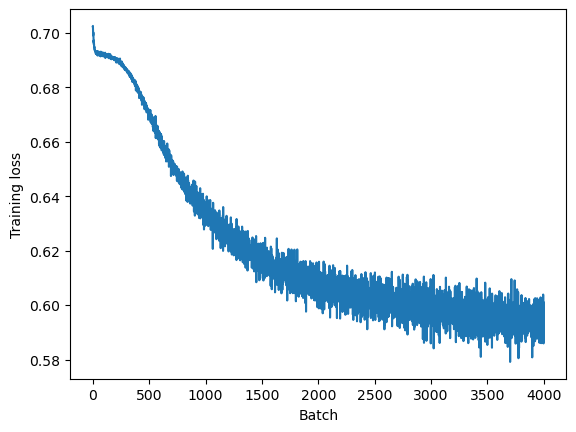

In [13]:
nlp.set_seed(SEED)
net = nlp.Net('ReLU()', nFeatures_emo, [50], 2).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 1000

_, _ = nlp.train_test_classification(net, criterion, optimizer, emo_train_loader,
                                 emo_val_loader, num_epochs=num_epochs,
                                 training_plot=True, device=DEVICE)

Run MLP on word embeddings

Random seed 1228472244 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy on the 24000 training samples: 99.99
Accuracy on the 6000 testing samples: 96.90


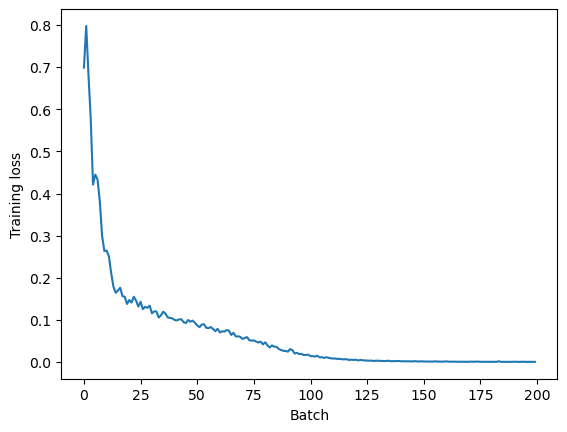

In [54]:
nlp.set_seed(SEED)
net = nlp.Net('ReLU()', nFeatures_embed, [1000, 1000], 2).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 50

_, _ = nlp.train_test_classification(net, criterion, optimizer, embed_train_loader,
                                 embed_val_loader, num_epochs=num_epochs,
                                 training_plot=True, device=DEVICE)

Run MLP on merged features (emotional scores + embedding)

Random seed 278341638 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy on the 24000 training samples: 100.00
Accuracy on the 6000 testing samples: 97.02


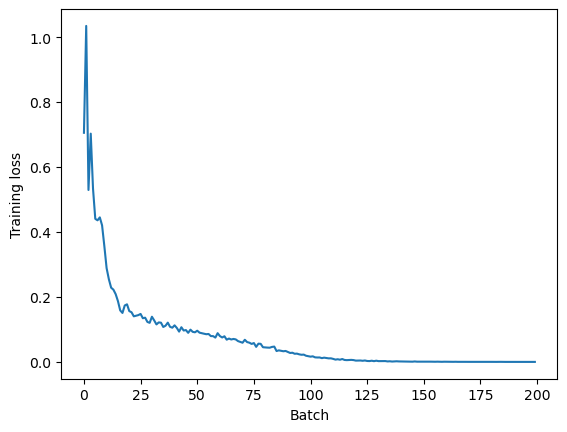

In [58]:
nlp.set_seed(SEED)
net = nlp.Net('ReLU()', nFeatures_embed+nFeatures_emo, [1000, 1000], 2).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 50

_, _ = nlp.train_test_classification(net, criterion, optimizer, merged_train_loader,
                                 merged_val_loader, num_epochs=num_epochs,
                                 training_plot=True, device=DEVICE)


Run MLP on embeddings computed separately

Random seed 5 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy on the 24000 training samples: 100.00
Accuracy on the 6000 testing samples: 96.92


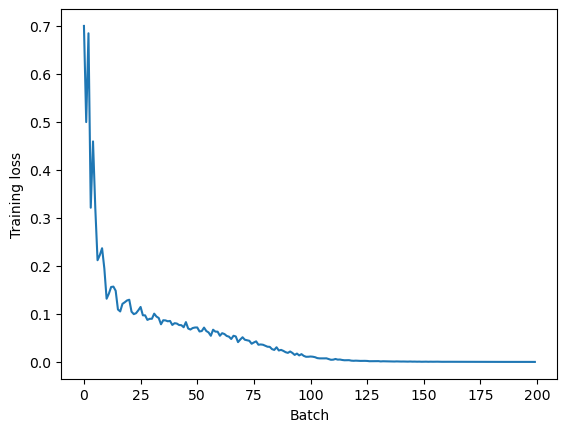

In [24]:
nlp.set_seed(SEED)
net = nlp.Net('ReLU()', nFeatures_embed, [1000, 1000], 2).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 50

_, _ = nlp.train_test_classification(net, criterion, optimizer, train_loader_separate,
                                 val_loader_separate, num_epochs=num_epochs,
                                 training_plot=True, device=DEVICE)